In [1]:
!pip uninstall --quiet captum
!pip install --quiet captum

In [30]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [32]:
!nvidia-smi

Mon Apr 18 21:31:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:84:00.0 Off |                    0 |
| N/A   50C    P0    40W / 250W |   2412MiB / 16384MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [92]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = torchvision.datasets.ImageFolder(root='dataset/train', transform=transform)
test_data = torchvision.datasets.ImageFolder(root='dataset/test', transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=8, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=8, shuffle=True, num_workers=4)


classes = ('Amsterdam', 'Firenca', 'LasVegas', 'NYC')

In [91]:
import torch.nn as nn
import torch.nn.functional as F

class LongcatNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(3, 9, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2_bn = nn.BatchNorm2d(9)
        self.conv2 = nn.Conv2d(9, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3_bn = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 25, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4_bn = nn.BatchNorm2d(25)
        self.conv4 = nn.Conv2d(25, 36, 3)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.conv5_bn = nn.BatchNorm2d(36)
        self.conv5 = nn.Conv2d(36, 36, 3)
  
        self.conv6_bn = nn.BatchNorm2d(36)
        self.conv6 = nn.Conv2d(36, 49, 3)

        self.conv7_bn = nn.BatchNorm2d(49)
        self.conv7 = nn.Conv2d(49, 49, 3)
        
        self.conv8_bn = nn.BatchNorm2d(49)
        self.conv8 = nn.Conv2d(49, 49, 3)
        
        self.conv9_bn = nn.BatchNorm2d(49)
        self.conv9 = nn.Conv2d(49, 49, 3)
        self.pool9 = nn.MaxPool2d(2, 2)

        self.conv10_bn = nn.BatchNorm2d(49)
        self.conv10 = nn.Conv2d(49, 49, 3)
        self.pool10 = nn.MaxPool2d(2, 2)

        self.fc = nn.Linear(1764, 4)

    def forward(self, x):
        x = self.bn1(x)
        x = self.conv2_bn(self.pool1(F.relu(self.conv1(x))))
        x = self.conv3_bn(self.pool2(F.relu(self.conv2(x))))
        x = self.conv4_bn(self.pool3(F.relu(self.conv3(x))))
        x = self.conv5_bn(self.pool4(F.relu(self.conv4(x))))

        x = self.conv6_bn(F.relu(self.conv5(x)))  
        x = self.conv7_bn(F.relu(self.conv6(x)))
        x = self.conv8_bn(F.relu(self.conv7(x)))
        x = self.conv9_bn(F.relu(self.conv8(x)))
        
        
        x = self.conv10_bn(self.pool9(F.relu(self.conv9(x))))
        x = self.pool10(F.relu(self.conv10(x)))
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = self.fc(x)
        return x


longcat = LongcatNet()
longcat = longcat.to(device)

longcat.load_state_dict(torch.load('saved_models/longcat/epoch_7_batch_5000.pth', map_location=device))
longcat.eval()

LongcatNet(
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_bn): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 25, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_bn): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(25, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5_bn): BatchNorm2d(36, eps=

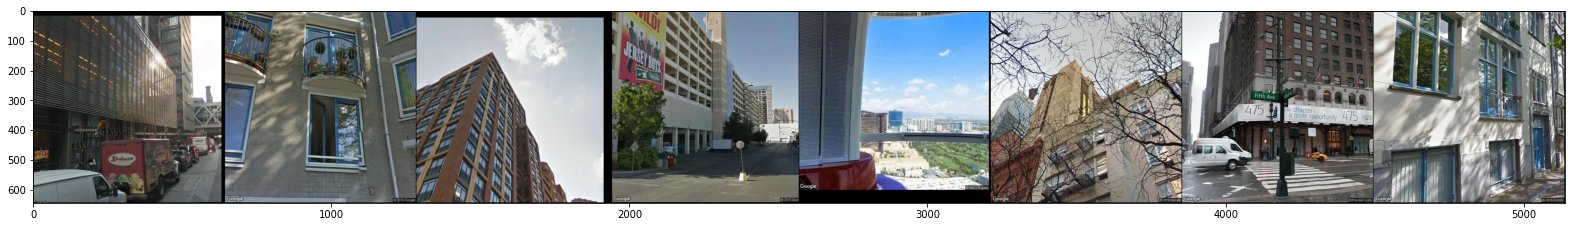

GroundTruth:    NYC Amsterdam   NYC LasVegas LasVegas   NYC   NYC Amsterdam
Predicted:    NYC Firenca   NYC LasVegas


In [102]:
def imshow(img, transpose = True):
    npimg = img.numpy()
    fig, ax = subplots(figsize=((22, 8)))
    tight_layout()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))


outputs = longcat(images.cuda())

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [79]:
from PIL import Image

imgg = Image.open(test_loader.dataset.samples[55][0])

Populating the interactive namespace from numpy and matplotlib


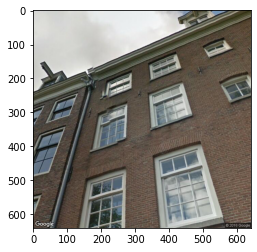

In [78]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(test_loader.dataset.samples[55][0])
plt.imshow(img)

In [103]:

ind = 0

input = images[ind].unsqueeze(0)
input.requires_grad = True

In [104]:
def attribute_image_features(algorithm, input, **kwargs):
    longcat.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [106]:
saliency = Saliency(longcat)
grads = saliency.attribute(input.cuda(), target=labels[ind].item())
grads = np.transpose(grads.cpu().squeeze(), (1, 2, 0))

In [107]:
ig = IntegratedGradients(longcat)
attr_ig, delta = attribute_image_features(ig, input.cuda(), baselines=input.cuda() * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.1920], device='cuda:0', dtype=torch.float64)


In [105]:
ig = IntegratedGradients(longcat)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input.cuda(), baselines=input.cuda() * 0, nt_type='smoothgrad_sq',
                                      n_samples=4, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [108]:
dl = DeepLift(longcat)
attr_dl = attribute_image_features(dl, input.cuda(), baselines=input.cuda() * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

Original Image
Predicted: NYC  Probability: 1.0


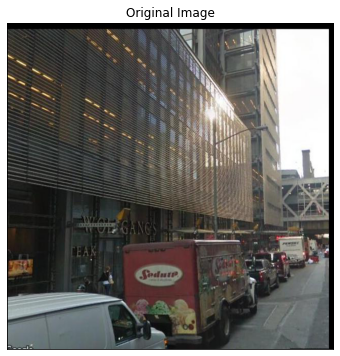

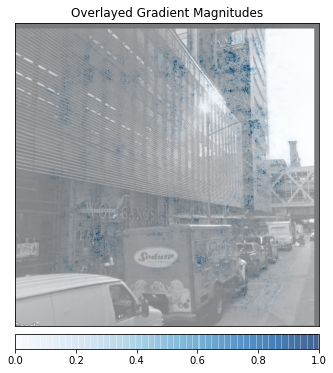

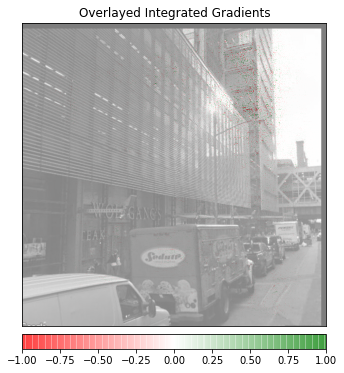

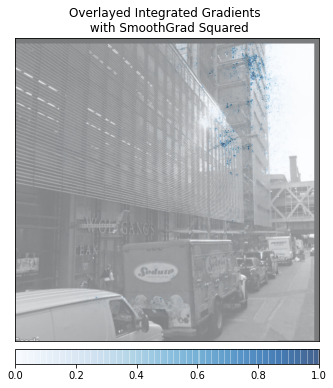

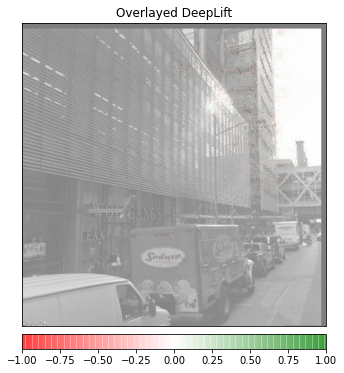

In [109]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy()), (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads.numpy(), original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")